In [1]:
# from https://pyparticleest.readthedocs.io/en/latest/example/StdNonLin.html
%matplotlib inline
import numpy as np
import math
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import matplotlib.pyplot as plt

Falling back to pure python implementaton, expect horrible performance


In [56]:
def generate_dataset(steps, P0, Q, R):
    x = np.zeros(steps + 1)
    y = np.zeros(steps + 1)
    x[0] = P0
    #y[0] = 0.05*x[0]**2 + np.random.normal(0, np.sqrt(R))
    #y[0] = x[0] + np.random.poisson(np.sqrt(R))
    y[0] = x[0] + np.random.normal(0, np.sqrt(R))
    for k in range(0, steps):
        #x[k + 1] = 0.5*x[k] + 25*x[k]/(1+x[k]**2) + 8*math.cos(1.2*k) + np.random.normal(0, np.sqrt(Q))
        #x[k + 1] = 0.5*x[k] + np.random.poisson(np.sqrt(Q))
        x[k + 1] = 0.5*x[k] + np.random.normal(0, np.sqrt(Q))
        #y[k + 1] = 0.05*x[k+1]**2 + np.random.normal(0, np.sqrt(R))
        #y[k + 1] = x[k+1] + np.random.poisson(np.sqrt(R))
        y[k + 1] = x[k+1] + np.random.normal(0, np.sqrt(R))

    return (x, y)

In [57]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = 0.5*x_k + 25.0*x_k/(1+x_k**2) +
    #           8*math.cos(1.2*k) + v_k = f(x_k) + v:
    # y_k = 0.05*x_k**2 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ N(0,R)

    def __init__(self, P0, Q, R):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q, R=R)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
        #return 0.05 * particles ** 2
        return particles

    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        #return (0.5 * particles + 25.0 * particles / (1 + particles ** 2) + 8 * math.cos(1.2 * t))
        return 0.5 * particles

In [58]:
T = 50 # number of iterations
P0 = np.array([0.1]) # initial state
Q = np.array([10]) # process noise
R = np.array([1]) # measurement noise

# Forward particles
N = 100
# Backward trajectories
M = 10

In [50]:
model = StdNonLin(P0, Q, R)

In [51]:
np.random.seed(0)
(x, y) = generate_dataset(T, P0, Q, R)

In [52]:
sim = simulator.Simulator(model, u=None, y=y)
sim.simulate(N, M, filter='PF', meas_first=True)

49

In [53]:
(est_filt, w_filt) = sim.get_filtered_estimates()
mean_filt = sim.get_filtered_mean()

In [54]:
est_smooth = sim.get_smoothed_estimates()

mean_smooth = sim.get_smoothed_mean()

Text(0,0.5,'x')

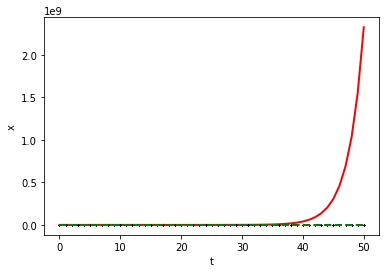

In [55]:
plt.plot(range(T + 1), x, 'r-', linewidth=2.0, label='True')
plt.plot((0,) * N, est_filt[0, :, 0].ravel(), 'k.',
        markersize=0.5, label='Particles')
for t in range(1, T + 1):
    plt.plot((t,) * N, est_filt[t, :, 0].ravel(),
             'k.', markersize=0.5)
plt.plot(range(T + 1), mean_filt[:, 0], 'g--',
         linewidth=2.0, label='Filter mean')
plt.xlabel('t')
plt.ylabel('x')

In [21]:
np.save('estimates/pf_x_g.npy', mean_filt[:, 0])